In [69]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
import time
import datetime as dt
import re
import numpy as np
import pandas as pd
from stock_scraper import get_stock_prices
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
import requests

from Markowitz import get_vol, opt_weight

%matplotlib inline

In [70]:
from IPython.display import HTML

In [71]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [72]:
def convert_to_df(df_str):
    header = re.findall("[ , \w]+\\n", df_str)[1]
    columns = re.findall("[\w]+", header)
    number_cols = len(columns) + 1 # Including index as column
    
    n = len(columns)
    all_numbers = re.findall("[-,.,0-9]+", df_str)
    values = [float(all_numbers[i]) for i in range(len(all_numbers)) if i % number_cols != 0]
    vals_array = np.array(values).reshape((int(len(values) / n), n))
    
    tickers = re.findall('\[(.*)\]', df_str)
    
    result_df = pd.DataFrame(index=tickers, data=vals_array, columns=columns)
    
    return result_df

In [157]:
driver = webdriver.Chrome("/Users/Badre/Desktop/Developer/Selenium_Webdrivers/chromedriver")

# Get to algorithm login page
driver.get("https://www.quantopian.com/live_algorithms/5ac7078347a9990019bd2395")

# Log in and proceed to live trading page
username = driver.find_element_by_id("user_email")
password = driver.find_element_by_id("user_password")
username.send_keys("cib.pairs@gmail.com")
password.send_keys("CIBPairs17")
password.send_keys(Keys.ENTER)
time.sleep(0.5)

# Go to the logs pane
driver.find_element_by_css_selector("i.fontello-icon.fontello-icon-book").click()
        
    
# Wait until logs are displayed
print("Waiting for logs...")
weights_showing = False
while not weights_showing:
    try:
        driver.find_element_by_css_selector("div.logs-footer.hidden")
    except NoSuchElementException:
        time.sleep(3)
        continue
        
    print("Done")
    weights_showing = True
    
    
# Extract weights and tickers
weights_msg = driver.find_elements_by_xpath("//*[@class='logmsg' and contains(text(), 'WEIGHTS:')]")
weights_txt = weights_msg[0].text

tickers = re.findall('\[(.*)\]', weights_txt)
weights = re.findall('[-,.,0-9]+\\n', weights_txt)
weights = [el.replace('\n', '') for el in weights]
weights = [float(weight) for weight in weights]
       
portfolio = pd.Series(index = tickers, data = weights)
print("\nAlgo picks:\n" + str(portfolio))

# Extract scores of stocks picked
scores_msg = driver.find_elements_by_xpath("//*[@class='logmsg' and contains(text(), 'FACTOR SCORES:')]")
scores_txt = scores_msg[0].text
scores_df = convert_to_df(scores_txt)

# Extract scores of bottom ranked stocks
bottom_scores_msg = driver.find_elements_by_xpath("//*[@class='logmsg' and contains(text(), 'BOTTOM SCORES:')]")
bottom_scores_txt = bottom_scores_msg[0].text
bottom_scores_df = convert_to_df(bottom_scores_txt)

# Extract scores of top ranked stocks
top_scores_msg = driver.find_elements_by_xpath("//*[@class='logmsg' and contains(text(), 'TOP SCORES:')]")
top_scores_txt = top_scores_msg[0].text
top_scores_df = convert_to_df(top_scores_txt)


print("\nPortfolio Scores:\n", scores_df)
print("\nBottom Scores:\n", bottom_scores_df)
print("\nTop Scores:\n", top_scores_df)

time.sleep(5)
driver.close()

Waiting for logs...
Done

Algo picks:
ICPT   -0.404929
ES     -0.310759
INNT   -0.284312
CHFS    0.303532
MNKD    0.316777
CNAT    0.379691
dtype: float64

Portfolio Scores:
       composite  momentum  sentiment   value
ICPT    -0.5729   -1.0545    -0.1782 -0.3991
ES      -0.4960   -1.0045    -0.1747 -0.1217
INNT    -0.0934    0.0000    -0.2334  0.0000
CHFS     0.3336    0.0000     0.1268  1.4142
MNKD     0.4106    1.2041     0.0247 -0.4045
CNAT     0.6103    1.1925     0.3651 -0.0636

Bottom Scores:
       composite  momentum  sentiment   value
ICPT    -0.5729   -1.0545    -0.1782 -0.3991
ES      -0.4960   -1.0045    -0.1747 -0.1217
INNT    -0.0934    0.0000    -0.2334  0.0000
GS      -0.2208    0.0000    -0.4894 -0.1252
BTG     -0.1926    0.0000    -0.4206 -0.1218
TWTR    -0.1698    0.0000    -0.1725 -0.5039
TEUM    -0.2581    0.0000    -0.1466 -0.9972
ELF     -0.1664    0.0000    -0.3552 -0.1217
JPM     -0.2055    0.0000    -0.1421 -0.7432
GOOG    -0.1648    0.0000    -0.1628 -0.498

In [214]:
SPY_EXPECTED_RETURN = 0.08
def get_expected_returns(tickers, scores, portfolio_expected_return=SPY_EXPECTED_RETURN):
    url = "http://finance.yahoo.com/quote/{ticker}/"
    mkt_caps = np.ones((len(tickers), 1))
    with requests.Session() as s:
        for i, ticker in enumerate(tickers):
            page = s.get(url.format(ticker=ticker))
            soup = BeautifulSoup(page.content, 'html.parser')
            mkt_cap = soup.findAll("td", {"data-test":"MARKET_CAP-value"})[0].text
            scale = mkt_cap[-1]
            value = float(mkt_cap[:-1])
            if scale == 'M':
                value /= 1000.0
            mkt_caps[i, 0] = value
    
    w = mkt_caps / sum(mkt_caps)
    s = np.array(scores).reshape((len(scores), 1))
    score_scaler = portfolio_expected_return / (w.T @ s)
    print("Score Scaler: ", score_scaler[0][0])
    score_scaler = np.abs(score_scaler[0][0]) # TODO: Potentially problematic. Need to address
    result = pd.Series(index=tickers, data=(score_scaler * scores))
            
    return result

# Analysis of Portfolio Picks

In [215]:
returns = get_expected_returns(portfolio.index, scores_df['composite'])

Score Scaler:  -0.16898157572261058


Raw Portfolio Picks


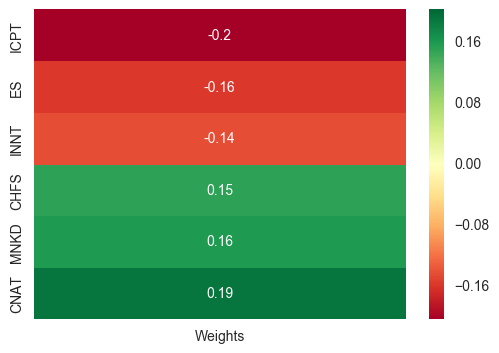

In [217]:
print("Raw Portfolio Picks")
sns.heatmap(pd.DataFrame(portfolio/2, columns=['Weights']), annot=True, cmap='RdYlGn')

Portfolio Factor Analysis


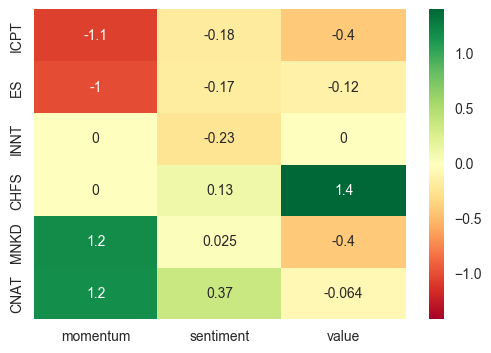

In [218]:
print("Portfolio Factor Analysis")
sns.heatmap(scores_df.drop(['composite'], axis=1), annot=True, cmap='RdYlGn')

In [219]:
COVAR_LOOKBACK = 90 # In days, not just business days
today = dt.date.today()
start = dt.date.today() - dt.timedelta(COVAR_LOOKBACK)
prices = get_stock_prices(portfolio.index, str(start), str(today))['Adj Close']

Succeeded in 1.76s after 1 attempts


In [220]:
try:
    null_locs = np.where(prices == 'null')
    for i in range(len(null_locs[0])):
        prices.iloc[null_locs[0][i], null_locs[1][i]] = np.nan
except:
    pass
prices = prices.fillna(method='pad')
prices = prices.apply(pd.to_numeric)
prices = prices.dropna(thresh=int(len(prices)*0.75), axis=1)

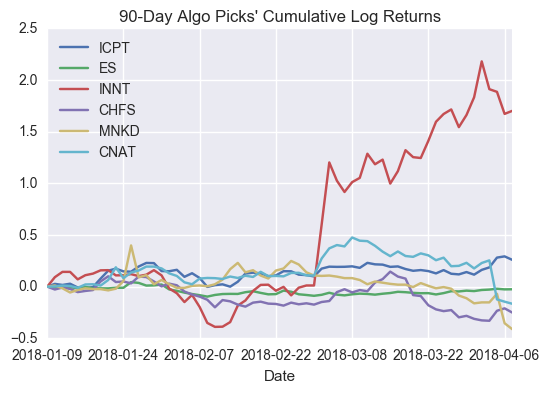

In [221]:
rets = prices.pct_change()

A = rets.dropna().T
A -= np.mean(A, axis=0)

cum_returns = (1 + rets.fillna(0)).cumprod()
np.log(cum_returns).plot(title='%d-Day Algo Picks\' Cumulative Log Returns' % COVAR_LOOKBACK)


2D PRINCIPLE COMPONENTS PROJECTION OF PAST 90 DAY RETURNS


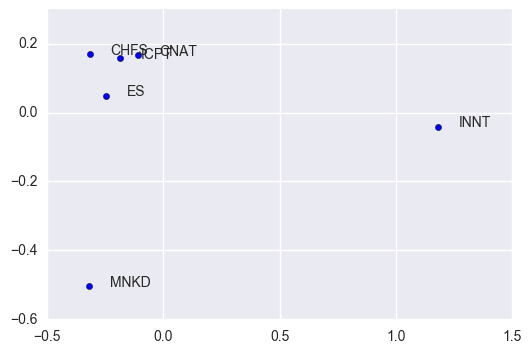

In [222]:
U, s, V = np.linalg.svd(A)
V = V.T
M = A @ V[:, :2]
print("2D PRINCIPLE COMPONENTS PROJECTION OF PAST %d DAY RETURNS" % COVAR_LOOKBACK)

fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(M[:, 0], M[:, 1])
for i in range(len(M)):
    ax.annotate(A.index[i], xy=(M[i, 0],M[i, 1]), xytext=(15,0), textcoords='offset points')

3D PRINCIPLE COMPONENTS PROJECTION OF PAST 90 DAY RETURNS


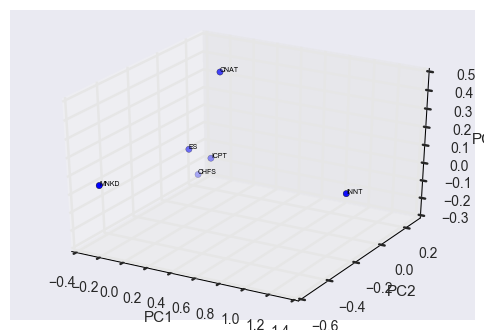

In [223]:
# Now let's project on 3 dimensions
from mpl_toolkits.mplot3d import Axes3D

M_3D = A @ V[:, :3]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = M_3D[:, 0]
ys = M_3D[:, 1]
zs = M_3D[:, 2]

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.scatter(xs, ys, zs)

for i in range(len(A)): #plot each point + it's index as text above
    ax.text(M_3D[i,0],M_3D[i,1],M_3D[i,2],  A.index[i], size=5, zorder=1,  
    color='k') 

print("3D PRINCIPLE COMPONENTS PROJECTION OF PAST %d DAY RETURNS" % COVAR_LOOKBACK)

ANNUALIZED COVARIANCE MATRIX FROM PAST 90 DAYS RETURNS


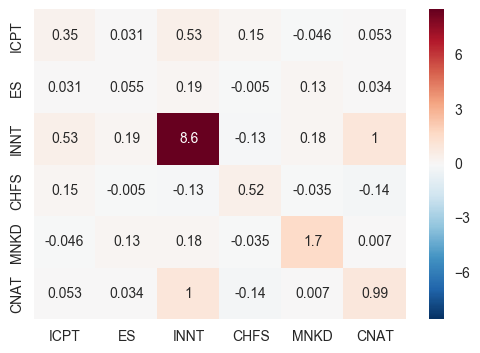

In [224]:
cov_mat = rets.dropna().cov() * 252
print("ANNUALIZED COVARIANCE MATRIX FROM PAST %d DAYS RETURNS" % COVAR_LOOKBACK)
sns.heatmap(cov_mat, annot=True, center=0)

In [225]:
from sklearn.cluster import KMeans
def corr_matrix_data(X, num_clusters=3, x_labels = False):
    # demean the data
    X_demeaned = X - np.mean(X, 0) 
    
    _, _, V = np.linalg.svd(X_demeaned)
    V = V.T
    
    # get projected data
    X_proj = X_demeaned @ V[:, :num_clusters]
    
    # do some k-means clustering to identify which points are in which cluster
    km = KMeans(n_clusters = num_clusters)
    clusters = km.fit_predict(X_proj)
    
    # sort data based on identified clusters 
    t = X.copy()
    t['cluster'] = clusters
    t = t.sort_values("cluster")
    clusters = t['cluster']
    t = t.drop("cluster", 1)
    plt.imshow(t.T.corr(), "hot")
    plt.colorbar()
    plt.grid(False)
    plt.yticks(range(len(X)), t.index)
    if x_labels:
        plt.xticks(range(len(X)), t.index)
    
    return clusters

Unclustered Correlation Matrix Heat Map


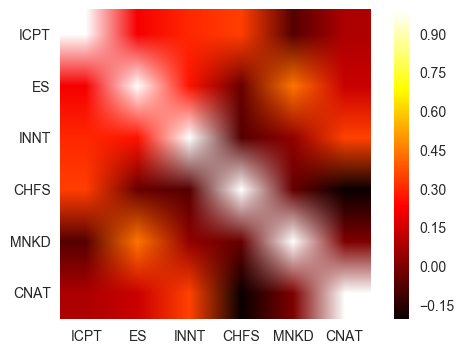

In [226]:
print("Unclustered Correlation Matrix Heat Map")
plt.imshow(rets.dropna().corr(), "hot")
plt.colorbar()
plt.grid(False)
_ = plt.xticks(range(rets.shape[1]), rets.columns)
_ = plt.yticks(range(rets.shape[1]), rets.columns)

2-Clustered Correlation Matrix Heat Map


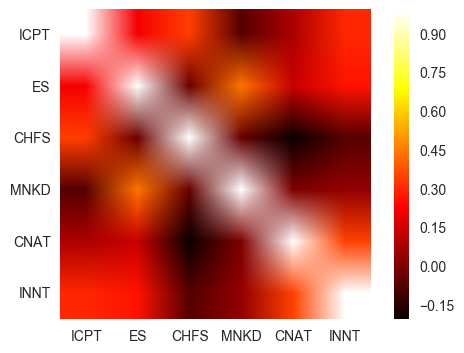

In [227]:
NUM_CLUSTERS = 2
print("%d-Clustered Correlation Matrix Heat Map" % NUM_CLUSTERS)
clusters = corr_matrix_data(rets.dropna().T, num_clusters=NUM_CLUSTERS, x_labels=True)

In [228]:
print("Groupings:\n" + str(clusters))

Groupings:
ICPT    0
ES      0
CHFS    0
MNKD    0
CNAT    0
INNT    1
Name: cluster, dtype: int32


In [229]:
return_sd = pd.DataFrame(index = A.index)
return_sd['E[r]'] = returns
return_sd['vol'] = [np.sqrt(cov_mat.iloc[i, i]) for i in range(len(cov_mat))]

In [230]:
def get_MVP(mu_vec, cov_mat, mark_vols, mark_rets, stocks):
    MVP_index = np.argmin(mark_vols)
    MVP = opt_weight(mark_rets[MVP_index], cov_mat, mu_vec)
    MVP_series = pd.Series(index=stocks, data=MVP.reshape((len(MVP))))
    print("Minimum Variance Portfolio:\n" + str(MVP_series.sort_values()))
    
    return MVP_series

In [231]:
def get_market_port(mu_vec, cov_mat, mark_vols, mark_rets, rf, stocks):
    derivatives = []
    for i in range(1, len(mark_rets) - 1):
        derivative = (mark_rets[i + 1] - mark_rets[i - 1]) / (mark_vols[i + 1] - mark_vols[i - 1])
        derivatives.append(derivative)
        
    cap_mkts_slopes = []
    for i in range(1, len(mark_rets) - 1):
        cap_mkts_slope = (mark_rets[i] - rf) / mark_vols[i]
        cap_mkts_slopes.append(cap_mkts_slope)
        
    MVP_index = np.argmax(derivatives)
    market_portfolio_index = np.argmin((np.array(derivatives[MVP_index:]) - np.array(cap_mkts_slopes[MVP_index:]))**2)
    market_portfolio_index += MVP_index
    market_portfolio_ret = mark_rets[market_portfolio_index - 1]
    market_portfolio = opt_weight(market_portfolio_ret, cov_mat, mu_vec)
    market_port_series = pd.Series(index=stocks, data=market_portfolio.reshape((len(market_portfolio))))
    
    cap_mkt_slope = cap_mkts_slopes[market_portfolio_index]
    
    print("Market Portfolio, assuming risk-free rate of %.2f:\n" % rf + str(market_port_series.sort_values()))
    
    return market_port_series, cap_mkt_slope
    

In [244]:
RF_RATE = 0.03

def plot_eff_front(mu_vec, cov_mat, stocks):
    mu_vec = mu_vec.reshape((len(mu_vec), 1))
    rets = np.linspace(-2 * np.abs(min(mu_vec)), 10*np.abs(max(mu_vec)), 100)
    vols = [get_vol(opt_weight(r, cov_mat, mu_vec), cov_mat) for r in rets]
    
    MVP = get_MVP(mu_vec, cov_mat, vols, rets, stocks)
    market_port, cap_mkt_slope = get_market_port(mu_vec, cov_mat, vols, rets, RF_RATE, stocks)
    x = np.linspace(0, max(vols), 100)
    cap_mkts_line = [RF_RATE + cap_mkt_slope*x for x in x]
    
    plt.plot(vols, rets)
    plt.plot(x, cap_mkts_line)
    plt.xlim(xmin=0)
    
    return MVP, market_port

In [245]:
print("Return-Volatility Table:\n", return_sd)

Return-Volatility Table:
           E[r]       vol
ICPT -0.096810  0.587910
ES   -0.083815  0.234826
INNT -0.015783  2.927657
CHFS  0.056372  0.719878
MNKD  0.069384  1.292283
CNAT  0.103129  0.994981


Minimum Variance Portfolio:
MNKD   -0.041965
INNT   -0.018968
ICPT    0.017354
CNAT    0.046882
CHFS    0.093482
ES      0.903214
dtype: float64
Market Portfolio, assuming risk-free rate of 0.03:
ES     -3.848533
ICPT   -1.834601
INNT    0.016899
MNKD    1.059574
CNAT    2.239102
CHFS    3.367559
dtype: float64


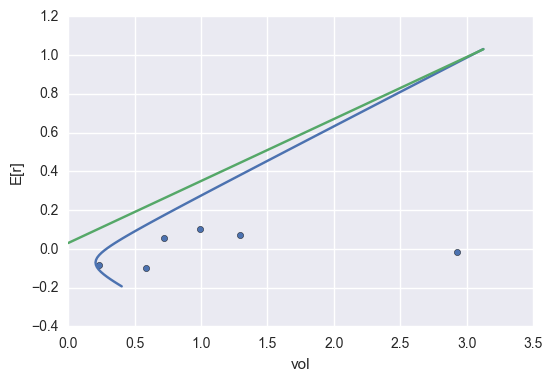

In [246]:
return_sd.plot.scatter(x='vol', y='E[r]')
MVP1, market_port1 = plot_eff_front(np.array(return_sd['E[r]']), np.array(cov_mat), return_sd.index)

In [247]:
def unlever_portfolio(portfolio):
    unlevered_port = portfolio.copy()
    short_sum = 0
    long_sum = 0
    for weight in unlevered_port:
        if weight < 0:
            short_sum -= weight
        else:
            long_sum += weight
            
    for i in range(len(unlevered_port)):
        if unlevered_port[i] < 0:
            unlevered_port[i] /= short_sum
        else:
            unlevered_port[i] /= long_sum

    if short_sum != 0:
        unlevered_port /= 2
            
    return unlevered_port

Unlevered Minimum Variance Portfolio


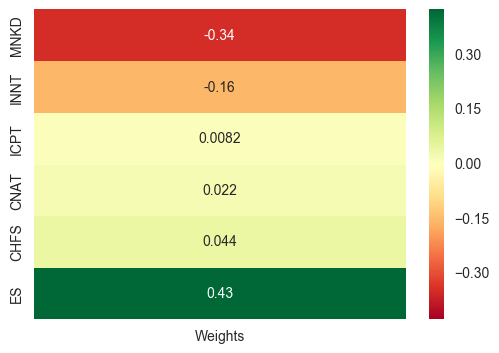

In [248]:
unlevered_MVP1 = unlever_portfolio(MVP1)
print("Unlevered Minimum Variance Portfolio")
sns.heatmap(pd.DataFrame(unlevered_MVP1, columns=['Weights']).sort_values('Weights'), annot=True, cmap='RdYlGn', center=0)

Unlevered Market Portfolio


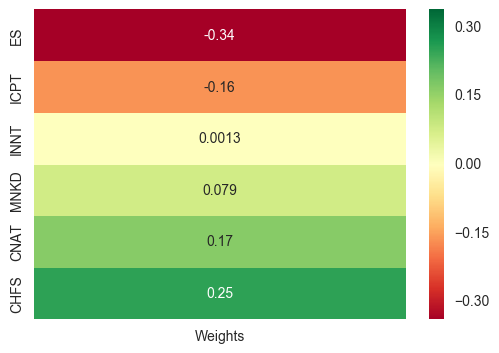

In [249]:
unlevered_market_port1 = unlever_portfolio(market_port1)
print("Unlevered Market Portfolio")
sns.heatmap(pd.DataFrame(unlevered_market_port1, columns=['Weights']).sort_values('Weights'), annot=True, cmap='RdYlGn', center=0)

# Analysis of Other Top and Bottom Stocks

In [250]:
all_scores = pd.concat([bottom_scores_df, top_scores_df], axis=0)
returns = get_expected_returns(all_scores.index, all_scores['composite'])

Score Scaler:  -0.8029039791566671


Factor Analysis


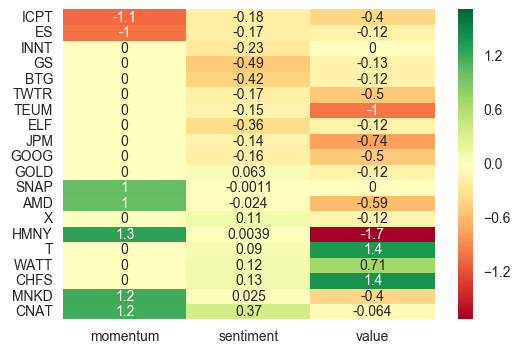

In [192]:
print("Factor Analysis")
sns.heatmap(all_scores.drop(['composite'], axis=1), annot=True, cmap='RdYlGn')

In [193]:
COVAR_LOOKBACK = 90 # In days, not just business days
today = dt.date.today()
start = dt.date.today() - dt.timedelta(COVAR_LOOKBACK)
prices = get_stock_prices(all_scores.index, str(start), str(today))['Adj Close']

Succeeded in 2.56s after 1 attempts


In [194]:
try:
    null_locs = np.where(prices == 'null')
    for i in range(len(null_locs[0])):
        prices.iloc[null_locs[0][i], null_locs[1][i]] = np.nan
except:
    pass
prices = prices.fillna(method='pad')
prices = prices.apply(pd.to_numeric)
prices = prices.dropna(thresh=int(len(prices)*0.75), axis=1)

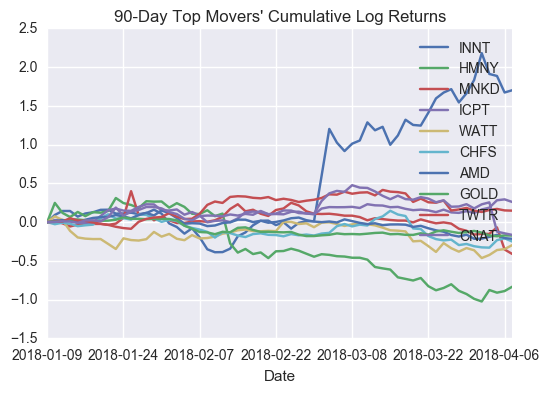

In [195]:
rets = prices.pct_change()

A = rets.dropna().T
A -= np.mean(A, axis=0)


cum_returns = (1 + rets.fillna(0)).cumprod()
top_movers = np.abs(cum_returns.iloc[-1] - 1).sort_values(ascending=False).head(10).index
np.log(cum_returns)[top_movers].plot(title='%d-Day Top Movers\' Cumulative Log Returns' % COVAR_LOOKBACK)


2D PRINCIPLE COMPONENTS PROJECTION OF PAST 90 DAY RETURNS


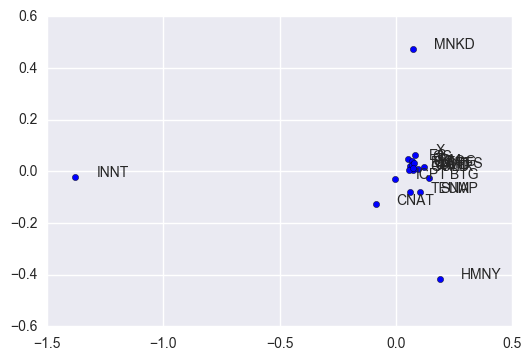

In [196]:
U, s, V = np.linalg.svd(A)
V = V.T
M = A @ V[:, :2]
print("2D PRINCIPLE COMPONENTS PROJECTION OF PAST %d DAY RETURNS" % COVAR_LOOKBACK)

fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(M[:, 0], M[:, 1])
for i in range(len(M)):
    ax.annotate(A.index[i], xy=(M[i, 0],M[i, 1]), xytext=(15,0), textcoords='offset points')

3D PRINCIPLE COMPONENTS PROJECTION OF PAST 90 DAY RETURNS


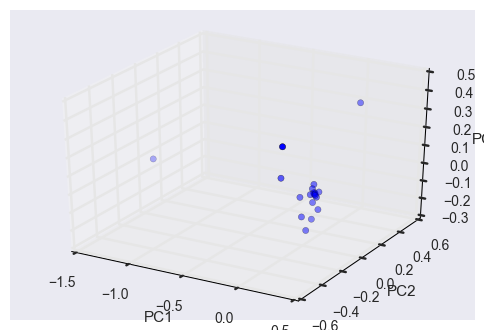

In [197]:
# Now let's project on 3 dimensions
from mpl_toolkits.mplot3d import Axes3D

M_3D = A @ V[:, :3]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = M_3D[:, 0]
ys = M_3D[:, 1]
zs = M_3D[:, 2]

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.scatter(xs, ys, zs)
    
print("3D PRINCIPLE COMPONENTS PROJECTION OF PAST %d DAY RETURNS" % COVAR_LOOKBACK)

ANNUALIZED COVARIANCE MATRIX FROM PAST 90 DAYS RETURNS


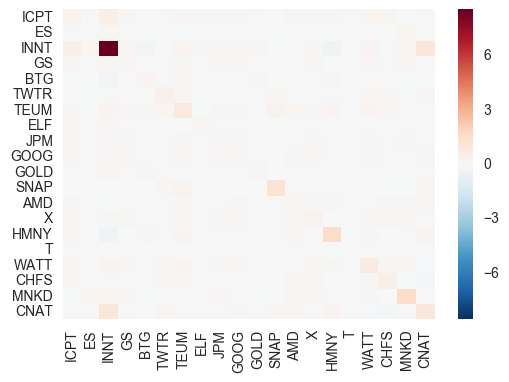

In [198]:
cov_mat = rets.dropna().cov() * 252
print("ANNUALIZED COVARIANCE MATRIX FROM PAST %d DAYS RETURNS" % COVAR_LOOKBACK)
sns.heatmap(cov_mat, annot=False, center=0)

Unclustered Correlation Matrix Heat Map


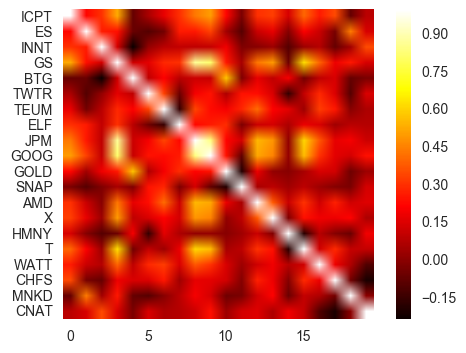

In [199]:
print("Unclustered Correlation Matrix Heat Map")
plt.imshow(rets.dropna().corr(), "hot")
plt.colorbar()
plt.grid(False)
_ = plt.yticks(range(rets.shape[1]), rets.columns)

3-Clustered Correlation Matrix Heat Map


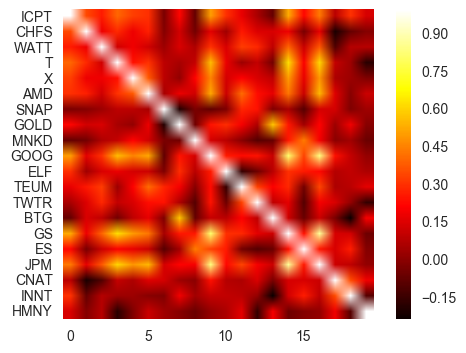

In [204]:
NUM_CLUSTERS = 3
print("%d-Clustered Correlation Matrix Heat Map" % NUM_CLUSTERS)
clusters = corr_matrix_data(rets.dropna().T, num_clusters=NUM_CLUSTERS)

In [205]:
print("Groupings:\n" + str(clusters))

Groupings:
ICPT    0
CHFS    0
WATT    0
T       0
X       0
AMD     0
SNAP    0
GOLD    0
MNKD    0
GOOG    0
ELF     0
TEUM    0
TWTR    0
BTG     0
GS      0
ES      0
JPM     0
CNAT    0
INNT    1
HMNY    2
Name: cluster, dtype: int32


In [206]:
return_sd = pd.DataFrame(index = A.index)
return_sd['E[r]'] = returns
return_sd['vol'] = [np.sqrt(cov_mat.iloc[i, i]) for i in range(len(cov_mat))]

In [207]:
print("Using scores as expected returns, Return-Volatility Table:\n", return_sd)

Using scores as expected returns, Return-Volatility Table:
           E[r]       vol
ICPT -0.459984  0.587910
ES   -0.398240  0.234826
INNT -0.074991  2.927657
GS   -0.177281  0.299449
BTG  -0.154639  0.473747
TWTR -0.136333  0.643149
TEUM -0.207230  0.925170
ELF  -0.133603  0.405219
JPM  -0.164997  0.264076
GOOG -0.132319  0.318922
GOLD  0.000723  0.328187
SNAP  0.332643  1.088223
AMD   0.223207  0.431657
X     0.017182  0.600682
HMNY  0.136574  1.290399
T     0.248418  0.224074
WATT  0.152632  0.873748
CHFS  0.267849  0.719878
MNKD  0.329672  1.292283
CNAT  0.490012  0.994981


Minimum Variance Portfolio:
GOOG   -0.243352
ICPT   -0.075613
BTG    -0.033453
MNKD   -0.030236
WATT   -0.017224
TEUM   -0.009306
INNT   -0.006268
CNAT   -0.004659
SNAP    0.006559
CHFS    0.007124
ELF     0.008207
AMD     0.012270
X       0.027104
HMNY    0.037046
TWTR    0.066092
GS      0.100638
JPM     0.124978
GOLD    0.220532
T       0.379018
ES      0.430542
dtype: float64
Market Portfolio, assuming risk-free rate of 0.03:
JPM     -8.299165
ES      -6.534892
GS      -4.898812
ICPT    -1.992360
BTG     -1.260658
TWTR    -0.978593
TEUM    -0.210536
CHFS    -0.056205
ELF     -0.035790
CNAT     0.136504
INNT     0.168285
HMNY     0.442301
SNAP     0.501056
MNKD     0.596083
X        1.222432
WATT     1.227370
AMD      1.890454
GOLD     3.161169
GOOG     4.487739
T       11.433618
dtype: float64


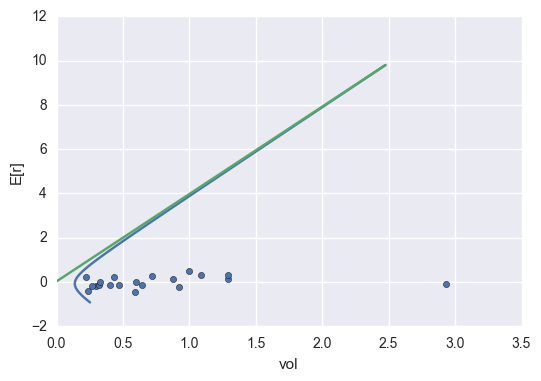

In [208]:
return_sd.plot.scatter(x='vol', y='E[r]')
MVP2, market_port2 = plot_eff_front(np.array(return_sd['E[r]']), np.array(cov_mat), return_sd.index)

Unlevered Minimum Variance Portfolio


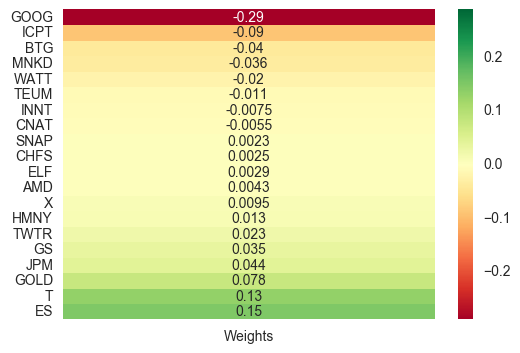

In [209]:
unlevered_MVP2 = unlever_portfolio(MVP2)
print("Unlevered Minimum Variance Portfolio")
sns.heatmap(pd.DataFrame(unlevered_MVP2, columns=['Weights']).sort_values('Weights'), annot=True, cmap='RdYlGn', center=0)

Unlevered Market Portfolio


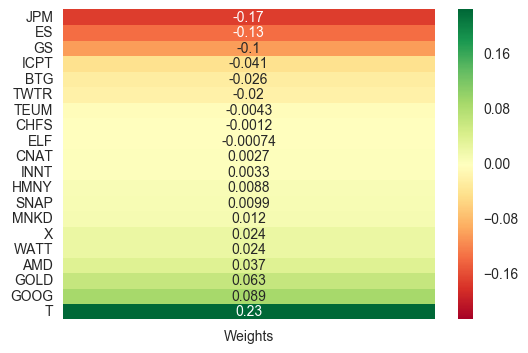

In [210]:
unlevered_market_port2 = unlever_portfolio(market_port2)
print("Unlevered Market Portfolio")
sns.heatmap(pd.DataFrame(unlevered_market_port2, columns=['Weights']).sort_values('Weights'), annot=True, cmap='RdYlGn', center=0)